In [1]:
from PIL import Image, ImageFilter, ImageStat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy import signal

# Load file names and labels
df = pd.read_csv('dataset/label_data.csv')    

# Task A

## Feature extraction

In [40]:
# Loop over all images and calculate simple initial features such as average pixel intensity, entropy, etc.
# avg = []
# ent = []
# var = []
# ratioh = []
# ratiov = []
# ratiod = []
for idx,filename in enumerate(df.loc[:,'file_name']):
    im = Image.open('dataset/image/'+filename).convert('L')
    # ent.append(im.entropy())
    # avg.append(ImageStat.Stat(im).mean[0])
    # var.append(ImageStat.Stat(im).var[0])

    # im = np.array(im) # convert to numpy array
    # left=0
    # right=0
    # top=0
    # bottom=0
    # for j in range(0,512):
    #     for k in range(0,512):
    #         if k>=256:
    #             top = top+im[j,k]
    #         else:
    #             bottom = bottom+im[j,k]
            
    #         if j>=256:
    #             right = right+im[j,k]
    #         else:
    #             left = left+im[j,k]
            # if j>k:
            #     top = top+im[j,k]
            # else:
            #     bottom = bottom+im[j,k]

    # ratiov.append(left/right)
    # ratioh.append(top/bottom)
    # ratiod.append(top/bottom)

# df['entropy'] = ent
# df['variance'] = var
# df['avg_pixel_intensity'] = avg
# df['Horizontal symmetry'] = ratioh
# df['Vertical symmetry'] = ratiov
# df['Diagonal symmetry'] = ratiod
# df.to_csv('dataset/label_data.csv',index=False)


In [18]:
images = []
for idx,filename in enumerate(df.loc[:,'file_name']):
    im = Image.open('dataset/image/'+filename).convert('L')
    def normalise(pixel):
        _,ma = im.getextrema()
        return pixel/ma*255
    im = Image.eval(im,normalise)
    im.save('dataset/image_std/'+filename)
#     images.append(np.array(im))

# images = np.asarray(images)
# plt.imshow(np.mean(images,axis=0))
    


<AxesSubplot:xlabel='entropy', ylabel='Horizontal symmetry'>

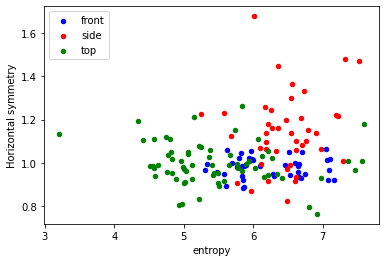

In [4]:
# Display images in feature space

# sick = df[df['tumour']]
# healthy = df[df['tumour']==False]

# ax = sick.plot('variance','entropy',kind='scatter',color='blue')
# healthy.plot('variance','entropy',kind='scatter',ax=ax,color='green')

front = df[df['perspective']=='front']
side = df[df['perspective']=='side']
top = df[df['perspective']=='top']

ax = front.plot('entropy','Horizontal symmetry',kind='scatter',color='blue',label='front')
side.plot('entropy','Horizontal symmetry',kind='scatter',color='red',ax=ax,label='side')
top.plot('entropy','Horizontal symmetry',kind='scatter',color='green',ax=ax,label='top')


## Image processing

In [10]:
# Create stacked numpy array of images

im_array = np.zeros((3000,512,512))
acc = 0
for filename in df.loc[:,'file_name']:
    im_array[acc,:,:] = np.array(Image.open('dataset/image/'+filename).convert('L'))
    acc+=1

im_array_sick = np.zeros((2546,512,512))
acc = 0
for filename in df.loc[df['tumour'],'file_name']:
    im_array_sick[acc,:,:] = np.array(Image.open('dataset/image/'+filename).convert('L'))
    acc+=1

im_array_healthy = np.zeros((454,512,512))
acc=0
for idx,filename in enumerate(df.loc[df['tumour']==False,'file_name']):
    im_array_healthy[acc,:,:] = np.array(Image.open('dataset/image/'+filename).convert('L'))
    acc+=1

In [82]:
acc = 0
for filename in df.loc[:,'file_name']:
    im = Image.open('dataset/image/'+filename).convert('L')
    mi,ma = im.getextrema()
    def normalise(pixel):
        return pixel/ma*255
    im = Image.eval(im,normalise)  
    hist = im.histogram()
    plt.bar(np.linspace(0,256,256),hist)
    def threshold(pixel):
        if pixel>125:
            return 255
        else:
            return 0 
    im = Image.eval(im,threshold)
    im_array[acc,:,:] = np.array(im)
    acc+=1

## Classification